# Machine Learning in Finance

Machine learning has rapidly become an important tool in finance, offering the potential to uncover complex patterns and improve decision-making across a variety of tasks. However, applying machine learning in financial contexts is far from straightforward. A key challenge stems from the large noise-to-signal ratio typical of financial data: true underlying structures often drown in random fluctuations, making it difficult to extract reliable information. As a result, finding simple, consistently successful use cases for machine learning in finance remains an ongoing challenge.

Nevertheless, the past decade has witnessed a significant rise in academic research applying machine learning to financial problems. Most of this work has centered around supervised learning — for example, predicting asset returns, classifying credit risk, or estimating the probability of default — and unsupervised learning, particularly clustering methods that group assets based on return similarities or risk factors. These approaches aim to tackle classic financial tasks with new tools, offering alternative ways to model complex dependencies, capture nonlinearities, and exploit hidden structures in data.

Beyond prediction and clustering, machine learning is increasingly used for anomaly detection (such as identifying fraudulent transactions), portfolio construction, risk management, and the analysis of unstructured data like news articles, earnings calls, and regulatory filings. These broader applications show that machine learning can contribute to many aspects of finance beyond mere forecasting.

At the same time, practitioners and researchers must be cautious. Machine learning methods often prioritize predictive accuracy at the cost of interpretability — a trade-off that is particularly critical in finance, where understanding model behavior is essential for regulatory compliance, investment decisions, and model risk management. Furthermore, most machine learning algorithms assume relatively stable data-generating processes, whereas financial markets are notoriously non-stationary: patterns can shift abruptly during crises or regime changes. This means models trained on past data may fail badly when market conditions evolve.

Another important concern is model risk and overfitting. Because financial datasets, despite their size, are often limited relative to the complexity of financial markets, machine learning models can easily overfit — capturing noise rather than meaningful signals. Rigorous out-of-sample testing, cross-validation, and robustness checks are necessary to ensure that models genuinely add value rather than exploiting chance patterns in historical data.

In this chapter, we take a look at a few examples for clustering and supervised learning. As we discussed portfolio optimization in a previous chapter, we start with the use of clustering to determine portfolio allocations.

## Clustering Assets by Dependence

In the previous chapter, we introduced clustering as a method for finding structure in data by grouping together observations that are similar to each other while ensuring that different groups remain as distinct as possible. Clustering algorithms seek to maximize within-group similarity and between-group dissimilarity, creating meaningful partitions of the data.

In many general machine learning applications, similarity between observations is often measured using metrics such as Euclidean distance or cosine similarity, depending on the nature of the data and the problem at hand. These measures work well when differences in magnitude or orientation capture the relationships of interest.

However, when we move into the financial domain — particularly when clustering assets such as stocks, bonds, or funds — it becomes more appropriate to define similarity in terms of statistical dependence rather than just geometric distance. A common and intuitive way to capture dependence between financial assets is through correlation measures, such as Pearson correlation (capturing linear relationships) or Spearman correlation (capturing monotonic relationships). In this setting, assets that move together closely over time are considered similar, even if their absolute levels or volatilities differ.

Let us go through the steps of clustering several assets by their correlation matrix step by step. Below is a heatmap which displays a correlation matrix of daily discrete returns for ten US stock market listed companies. Stock returns often come along with relatively high levels of positive correlation. This can be observed in our example as well, nevertheless, the landscape of correlation pairs is heterogen which gives us the possibility to form stock groups which are less correlated between. As a consequence if we distribute wealth accordingly, we may benefit from diversification. 

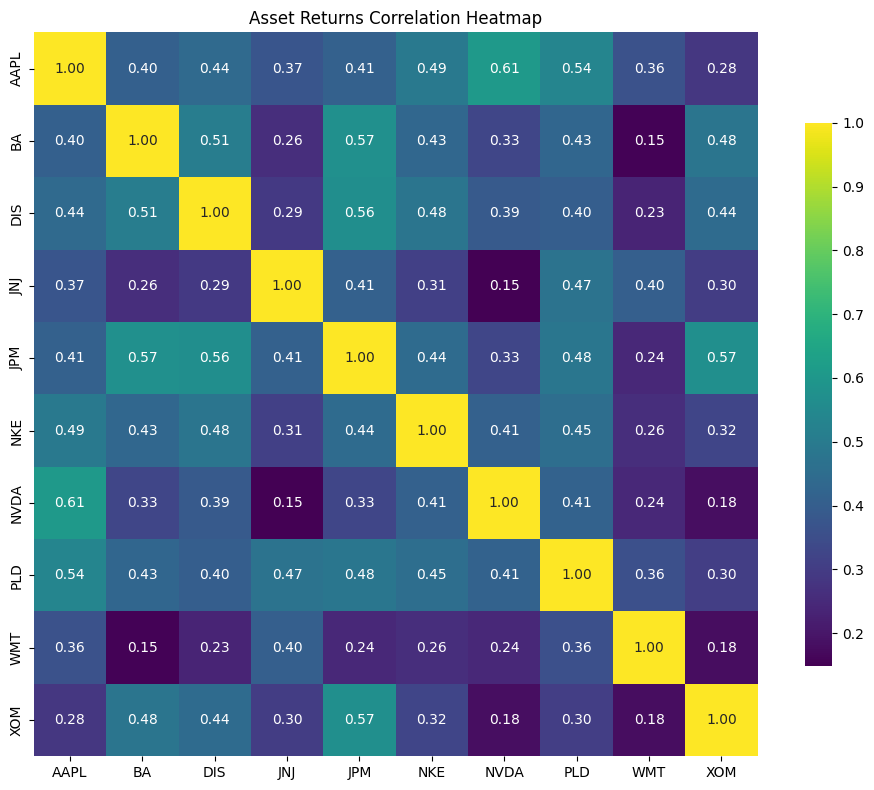

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

# Define tickers and their sectors
tickers = {
    "AAPL": "Apple Inc. (Technology)",
    "JNJ": "Johnson & Johnson (Healthcare)",
    "XOM": "Exxon Mobil Corp. (Energy)",
    "JPM": "JPMorgan Chase & Co. (Financials)",
    "WMT": "Walmart Inc. (Consumer Staples)",
    "NVDA": "NVIDIA Corp. (Semiconductors)",
    "DIS": "Walt Disney Co. (Communication Services)",
    "BA": "Boeing Co. (Industrials)",
    "NKE": "Nike Inc. (Consumer Discretionary)",
    "PLD": "Prologis Inc. (Real Estate)"
}

try:
    returns = pd.read_csv("../data/chapter_10/asset_returns_clustering.csv")
    returns["Date"] = pd.to_datetime(returns["Date"])
    returns.set_index("Date", inplace=True)
except FileNotFoundError:
    data = yf.download(list(tickers.keys()), start="2020-01-01", end="2024-12-31", auto_adjust=True)
    returns = data["Close"].pct_change().dropna()
    returns.reset_index().to_csv("../data/chapter_10/asset_returns_clustering.csv", index=False)

plt.figure(figsize=(10, 8))
sns.heatmap(returns.corr(), annot=True, fmt=".2f", cmap="viridis", square=True, cbar_kws={"shrink": 0.75})
plt.title('Asset Returns Correlation Heatmap')
plt.tight_layout()
plt.show()

### Distance Metrics

Hierarchical clustering algorithms are build upon dissimularity rather than similarity. This is why we need to transform the similarity measures correlation into a dissimilarity measure. Therefore, we need a **distance metric**: a function that quantifies how "far apart" two objects are from each other. A **distance metric** $d(x, y)$ must satisfy the following four properties:

1. **Non-negativity**  

    The distance between any two points is always non-negative:

    $$
    d(x, y) \geq 0 \quad \text{for all} \quad x, y
    $$

2. **Identity of Indiscernibles**  

   The distance between two points is zero if and only if they are identical:
   
   $$
   d(x, y) = 0 \quad \text{if and only if} \quad x = y
   $$

3. **Symmetry**  

   The distance from $x$ to $y$ is the same as the distance from $y$ to $x$:
   
   $$
   d(x, y) = d(y, x)
   $$

4. **Triangle Inequality**  

   The direct distance from $x$ to $z$ is always less than or equal to the sum of the distances via a third point $y$:
   
   $$
   d(x, z) \leq d(x, y) + d(y, z)
   $$

These properties ensure that distances behave in a way that is consistent with our geometric intuition.

### Distance Based on Correlation

A popular transformation that turns a correlation coefficient into a valid distance metric is:

$$
d_{ij} = \sqrt{\frac{1 - \rho_{ij}}{2}}
$$

where:
- $\rho_{ij}$ is the correlation between asset $i$ and asset $j$.

This transformation ensures that:
- Perfectly correlated assets ($\rho = 1$) have a distance of $d = 0$,
- Perfectly anti-correlated assets ($\rho = -1$) have a distance of $d = 1$,
- The resulting distance satisfies non-negativity, identity of indiscernibles, symmetry, and the triangle inequality.

This correlation-based distance is widely used for clustering assets in financial applications such as portfolio construction and risk management. Below you can take a look how the distance matrix looks like using the pairwise correlation values from the cell above. 

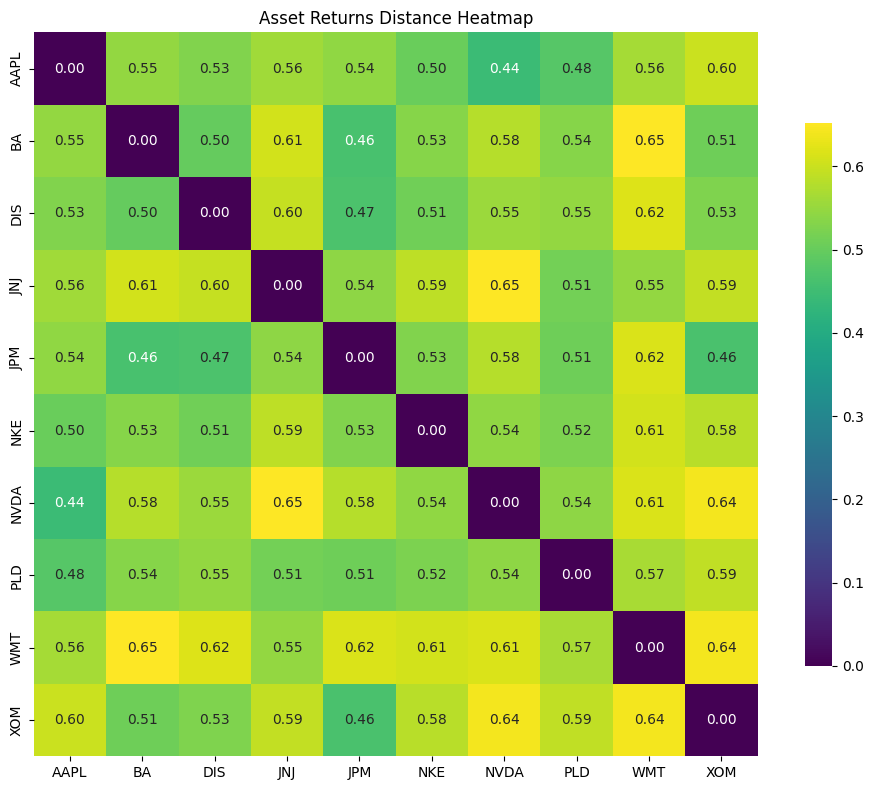

In [2]:
import numpy as np

corr = returns.corr()
dist = np.sqrt((1 - corr) / 2)

plt.figure(figsize=(10, 8))
sns.heatmap(dist, annot=True, fmt=".2f", cmap="viridis", square=True, cbar_kws={"shrink": 0.75})
plt.title('Asset Returns Distance Heatmap')
plt.tight_layout()
plt.show()

### Clustering with Distance Metrics

To understand in a more detailed way how we cluster according to the distance matrix, we go through the first steps iteratively using the example from above. We start hierarchical clustering using **single linkage** (minimum distance between clusters) based on the following distance matrix.

**Step 1**: Start with each asset as its own cluster:
- Clusters: {AAPL}, {BA}, {DIS}, {JNJ}, {JPM}, {NKE}, {NVDA}, {PLD}, {WMT}, {XOM}

**Step 2**: Find the **smallest distance** between any two clusters.

From the distance matrix:
- The smallest distance is between **NVDA** and **AAPL**:
  - Distance(NVDA, AAPL) = **0.4437**

-> Merge {NVDA} and {AAPL} into a new cluster {NVDA, AAPL}.


**Step 3**: Update the distance matrix.

- In **single linkage**, the distance between a cluster and another point (or cluster) is the **minimum distance** between any member of the two groups.
- For example:
  - Distance({NVDA, AAPL}, BA) = min(distance(NVDA, BA), distance(AAPL, BA)).

**Step 4**: Find the next smallest distance.

From the updated matrix:
- The next smallest distance is between **BA** and **JPM**:
  - Distance(BA, JPM) = **0.4624**

-> Merge {BA} and {JPM} into a new cluster {BA, JPM}.

**Step 5**: Update the distance matrix again.

- New cluster: {BA, JPM}.
- Distances to other clusters are computed using the **minimum** distance rule.

**Step 6**: Find the next smallest distance.

From the updated matrix:
- Distance between **XOM** and {BA, JPM}:
  - Distance(XOM, BA) = 0.510
  - Distance(XOM, JPM) = 0.465
  - Minimum = **0.465**

-> Merge {XOM} with {BA, JPM} into a larger cluster {BA, JPM, XOM}.

**Step 7**: Continue the process.

At each step:
- Find the **smallest available distance**,
- Merge the corresponding clusters,
- Update the distance matrix according to **single linkage** (minimum distance between points across clusters),
- Repeat until all assets are merged into one single cluster.

#### Important Notes

- **Single linkage** forms "chains" by always connecting the closest available clusters.
- It is **easy to perform manually** because only the **minimum distance** matters.
- After each merge, the number of clusters reduces by one.
- The clustering process can be visualized using a **dendrogram**, where the height of each merge represents the distance at which clusters were joined.

The dendogram for our example can be found in the cell below. 

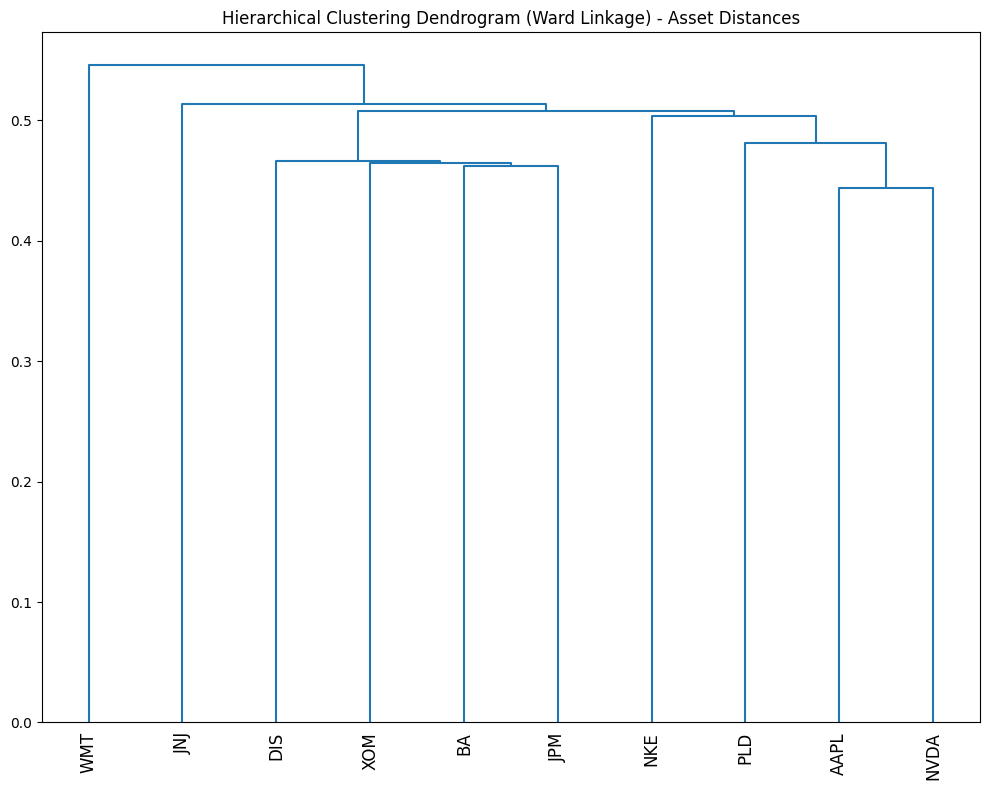

In [3]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform 

pairwise_distances = squareform(dist)
linkage_matrix = linkage(pairwise_distances, method = "single", optimal_ordering=False)
fig, ax = plt.subplots(figsize=(10,8)) 
dendrogram(
    linkage_matrix,
    labels=dist.columns,  
    leaf_rotation=90,     
    leaf_font_size=12,
    color_threshold=-np.inf 
)
plt.title('Hierarchical Clustering Dendrogram (Ward Linkage) - Asset Distances')
plt.tight_layout()
plt.show()

While **single linkage** is simple to understand and implement, it has some important limitations. Single linkage tends to produce long, "chain-like" clusters where new points are added based only on local proximity, often leading to poorly separated and elongated clusters. This effect, known as the **chaining phenomenon**, can result in clusters that are not compact or meaningful when analyzing financial assets.

In contrast, **Ward linkage** focuses on minimizing the **total within-cluster variance** at each step. When two clusters are merged, Ward's method chooses the pair whose combination results in the smallest possible increase in the overall within-cluster sum of squares. As a result, clusters produced by Ward linkage are typically more **compact**, **spherical**, and **well-separated**, making the clustering results more interpretable and stable — important properties when dealing with noisy and high-dimensional financial data.

Because of these advantages, Ward linkage is often preferred in financial clustering applications where clear and robust groupings of assets are desired. Take a look below how our example looks like when using Ward linkage. We are going to continue with this hierarchical clustering tree. 

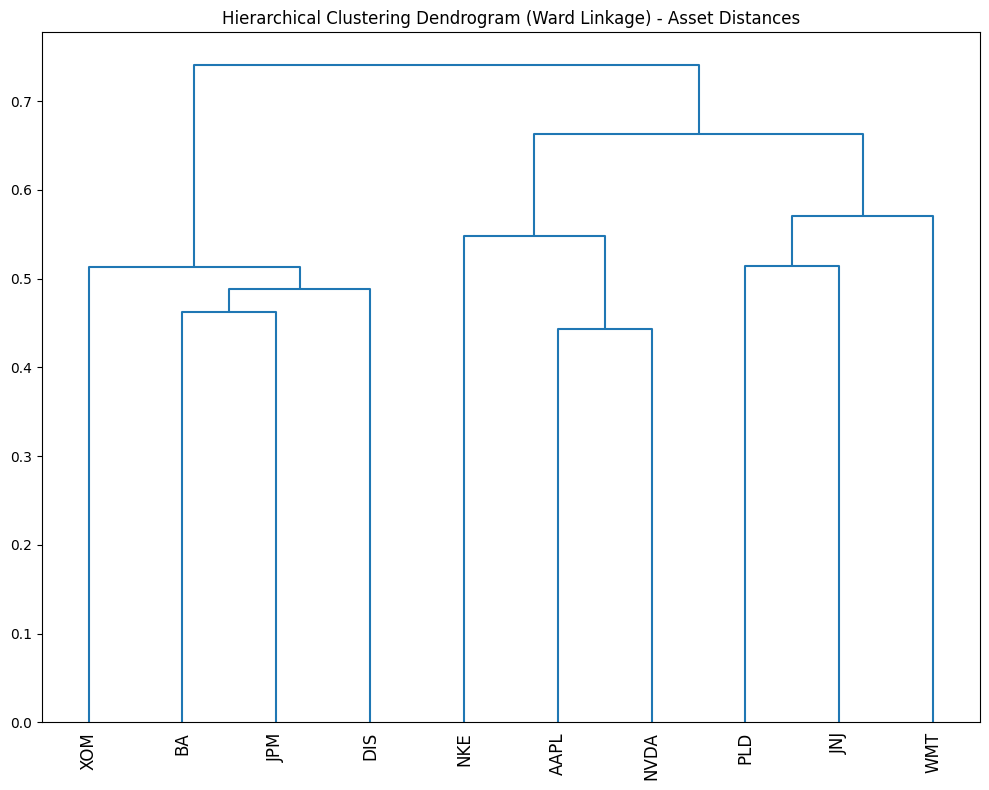

In [4]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform 

pairwise_distances = squareform(dist)
linkage_matrix = linkage(pairwise_distances, method = "ward", optimal_ordering=True)
fig, ax = plt.subplots(figsize=(10,8)) 
dendrogram(
    linkage_matrix,
    labels=dist.columns,  
    leaf_rotation=90,     
    leaf_font_size=12,
    color_threshold=-np.inf 
)
plt.title('Hierarchical Clustering Dendrogram (Ward Linkage) - Asset Distances')
plt.tight_layout()
plt.show()

### Choosing the Number of Clusters

As discussed in the previous chapter, hierarchical clustering requires the user to determine the final number of clusters. Conceptually, this is equivalent to **cutting the dendrogram vertically** at a certain height: all branches connected below the cut form separate clusters. 

The number of clusters can be selected based on a **fixed value** chosen by the user, either according to prior knowledge, interpretability, or practical needs. Alternatively, more **objective measures** can be used to guide the decision. One common approach is to compute the **standardized silhouette score**, which evaluates how similar an object is to its own cluster compared to other clusters. A higher silhouette score typically indicates more clearly separated and internally cohesive clusters, providing a useful metric for selecting an appropriate number of clusters in a data-driven way.

The **silhouette score** measures how well an object is matched to its own cluster compared to other clusters. For each observation $i$, the silhouette score $s(i)$ is defined as:

$$
s(i) = \frac{b(i) - a(i)}{\max\{a(i), b(i)\}}
$$

Given an observation $i$ belonging to cluster $C_i$:

- The **intra-cluster distance** $a(i)$ is defined as the average distance between $i$ and all other points within the same cluster $C_i$:

$$
a(i) = \frac{1}{|C_i| - 1} \sum_{\substack{j \in C_i \\ j \neq i}} d(i, j)
$$

where:
- $|C_i|$ is the number of points in cluster $C_i$,
- $d(i, j)$ is the distance between observations $i$ and $j$.

- The **nearest-cluster distance** $b(i)$ is defined as the minimum average distance between $i$ and all points in a different cluster $C$:

$$
b(i) = \min_{C \neq C_i} \left( \frac{1}{|C|} \sum_{j \in C} d(i, j) \right)
$$

where the minimum is taken over all clusters $C$ different from $C_i$.

Thus:
- $a(i)$ measures how well $i$ is assigned to its own cluster (lower is better),
- $b(i)$ measures how far $i$ is from its "best" neighboring cluster (higher is better).


The silhouette score $s(i)$ ranges between $-1$ and $+1$:
- $s(i) \approx +1$ indicates that the observation is well matched to its own cluster and poorly matched to neighboring clusters.
- $s(i) \approx 0$ indicates that the observation lies close to the decision boundary between two clusters.
- $s(i) \approx -1$ indicates that the observation may have been assigned to the wrong cluster.

The overall **silhouette score** for a clustering solution is the average $s(i)$ across all observations. A higher average silhouette score indicates better-defined and more separated clusters.

The silhouette score provides a simple way to evaluate the quality of a clustering. It compares how tightly grouped each point is within its own cluster (small $a(i)$) against how far away it is from the next nearest cluster (large $b(i)$). A good clustering will have high within-cluster similarity and low between-cluster similarity, leading to silhouette scores close to $+1$.

In the hierarichal clustering literature, it is proposed to standardize the silhoutte scores by averaging and dividing through their standard deviation. For a given number of clusters, we can determine the standardized silhouette score:

$$
q = \frac{\frac{1}{n} \sum_{i=1}^n s(i)} {\sqrt{\frac{1}{n} \sum_{i=1}^n \left( s(i) - \frac{1}{n} \sum_{i=1}^n s(i) \right)^2}}
$$

Finally, we choose the number of clusters which maximizes $q$. The cell below determines it for up to five clusters. We observe that three would be the best number of clusters in our example. 

In [5]:
import scipy.cluster.hierarchy as hr
from sklearn.metrics import silhouette_samples

cluster_lvls = pd.DataFrame(hr.cut_tree(linkage_matrix), index = dist.columns)
level_k = cluster_lvls.columns.tolist()

cluster_lvls = cluster_lvls.iloc[:, ::-1]
cluster_lvls.columns = level_k
cluster_k = cluster_lvls.nunique(axis=0).tolist()

max_k = 5
scores_list = []
n = dist.shape[0]

for k in cluster_k:
    if k == 1:
        scores_list.append(-np.inf)
    elif k > min(max_k, 5): #np.sqrt(n)
        break
    else:
        level = cluster_lvls[level_k[cluster_k.index(k)]]  
        b = silhouette_samples(dist, level)
        scores_list.append(b.mean() / b.std())

scores_list = pd.Series(scores_list)
k_index = int(scores_list.idxmax())
k = cluster_k[k_index]
scores_list = scores_list.to_frame("q")
scores_list.loc[:, "Cluster number"] = [i+1 for i in range(5)]
print(scores_list)

          q  Cluster number
0      -inf               1
1  1.393510               2
2  1.403226               3
3  1.338488               4
4  1.088693               5


### Recursive Bisection in Hierarchical Clustering

Now, we approach the question how to use the structure which has been revealed by clustering. An important concept in applying hierarchical clustering to practical problems, such as portfolio allocation, is **recursive bisection**. This approach involves traversing the clustering tree (dendrogram) from the top down and repeatedly splitting clusters into two subclusters at each step.

The key idea is to treat the dendrogram as a decision tree: starting with all assets grouped into a single cluster, the algorithm splits this cluster into two subgroups based on the clustering structure (typically from a linkage method like Ward or single linkage). Each subgroup is then recursively split again, until all leaves (individual assets) are reached.

Recursive bisection provides a structured way to exploit the hierarchy uncovered by clustering. It enables the user to assign values—such as weights, risks, or labels—to smaller and smaller groups while preserving the global structure of the data. This top-down traversal forms the backbone of algorithms like **Hierarchical Risk Parity (HRP)**, but has also been adapted in various ways for tasks such as asset allocation, feature grouping, and model ensembling.

For instance, assume we want to allocate money to the assets in our example with an emphasis on risk reduction (measured by volatilty). As clusters are derived on correlation, we know that correlation within cluster groups are higher than between cluster groups. While many different ideas have been provided in the academic literature, we follow a simplified recursive bisection. 

### Pseudocode: Recursive Bisection for Weight Allocation By Variance Contribution

The following algorithm recursively traverses a dendrogram to allocate weights across assets based on risk contributions. It assumes that the dendrogram provides a binary tree structure of asset groupings.

#### Inputs:
- Dendrogram representing the hierarchical clustering
- Covariance matrix $\Sigma$ of asset returns
- Minimum cluster size (optional stopping condition)

#### Initialization:
- Assign equal initial weights to all assets:  
  For each asset $i$:  
  $w_i \leftarrow 1$

#### Recursive Bisection Procedure:

a. From the top of the dendogram split the cluster into `left` and `right` subclusters based on the dendrogram.

b. Compute the **risk measure (RM)** of each subcluster using the assumption to build a naive portfolio for each subcluster:

$$
\text{RM}_1 = \sqrt{w_1^T \Sigma_1 w_1} \\
\text{RM}_2 = \sqrt{w_2^T \Sigma_2 w_2}
$$

where:
- $w_1$, $\Sigma_1$: weights and covariance submatrix for the left cluster,
- $w_2$, $\Sigma_2$: weights and covariance submatrix for the right cluster.

d. Compute the **risk weight**:
$$
\alpha = 1 - \frac{\text{RM}_1}{\text{RM}_1 + \text{RM}_2}
$$

e. Scale weights of the two subclusters:
- For all assets in the **left cluster**:  
    $w_i \leftarrow \alpha \cdot w_i$
- For all assets in the **right cluster**:  
    $w_i \leftarrow (1 - \alpha) \cdot w_i$

f. If the optimal number of clusters is reached **stop**, otherwise restart with step *a* for the next level of the dendogram.

After the weights have been determined, the weight for each company in the same cluster (at optimal cluster level) is the same, however weights are inverse proportional of the risk for the cluster portfolios. I.e., members of clusters with higher risk have lower weights. Finally, the weights are normalized to $\sum_i w_i = 1, w_i \geq 0 \forall i = 1, ..., n$. 

If you take a look in the dendogram above, you observe that the first split creates two subgroups:

- Left: XOM, BA, JPM, DIS
- Right: NKE, AAPL, NVDA, PLD, JNJ, WMT

If we determine the variance for a naive portfolio of the left group we get: $RM_1 = 0.00037$ and for the right group we get: $RM_2 = 0.00058$. This results in a weighting factor $\alpha = 0.6106$ because the left portfolio is less risky. Take a look in the cell output below which tracks the determination and updating of weights until the three clusters (optimal number according to silhouette scores) is reaced. 

In [6]:
assetslist = returns.columns.tolist()
root, nodes = hr.to_tree(linkage_matrix, rd=True)
nodes = np.array(nodes)
nodes_1 = np.array([i.dist for i in nodes])
idx = np.argsort(nodes_1)
nodes = nodes[idx][::-1].tolist()
weights = pd.Series(1.0, index=assetslist)

clustering_inds = hr.fcluster(linkage_matrix, k, criterion="maxclust")
clusters = {
    i: [] for i in range(min(clustering_inds), max(clustering_inds) + 1)
}
for i, v in enumerate(clustering_inds):
    clusters[v].append(i)

cov = returns.cov()

for nbr, i in enumerate(nodes[: k-1]):
    if i.is_leaf() == False:  # skip leaf-nodes
        left = i.get_left().pre_order()  # lambda i: i.id) # get left cluster
        right = i.get_right().pre_order()  # lambda i: i.id) # get right cluster
        left_set = set(left)
        right_set = set(right)
        left_risk = 0
        right_risk = 0
        left_cluster = []
        right_cluster = []

        for j in clusters.keys():
            if set(clusters[j]).issubset(left_set):
                cov_left = cov.iloc[clusters[j], clusters[j]].to_numpy()
                n_tmp = cov_left.shape[0]
                n_weights = np.ones(n_tmp) / n_tmp
                left_risk_ = n_weights.dot(cov_left).dot(n_weights)

                left_risk += left_risk_

            if set(clusters[j]).issubset(right_set):
                cov_right = cov.iloc[clusters[j], clusters[j]].to_numpy()
                n_tmp = cov_right.shape[0]
                n_weights = np.ones(n_tmp) / n_tmp
                right_risk_ = n_weights.dot(cov_right).dot(n_weights)

                right_risk += right_risk_
                
        alpha_1 = 1 - left_risk / (left_risk + right_risk)
    weights.iloc[left] *= alpha_1  
    weights.iloc[right] *= 1 - alpha_1  
    print(f"The variance of the left portfolio at dendogram level {nbr+1} is: {left_risk:.6f}")
    print(f"The variance of the left portfolio at dendogram level {nbr+1} is: {right_risk:.6f}")
    print(f"The risk based weightig for the left portfolio at dendogram level {nbr+1} is: {alpha_1:.4f}")
    print(f"The updated weights after determining the risk contribution at dendogram level {nbr+1} is:")
    print("-"*50)
    print(weights)
    print("-"*50)

The variance of the left portfolio at dendogram level 1 is: 0.000370
The variance of the left portfolio at dendogram level 1 is: 0.000580
The risk based weightig for the left portfolio at dendogram level 1 is: 0.6106
The updated weights after determining the risk contribution at dendogram level 1 is:
--------------------------------------------------
AAPL    0.389399
BA      0.610601
DIS     0.610601
JNJ     0.389399
JPM     0.610601
NKE     0.389399
NVDA    0.389399
PLD     0.389399
WMT     0.389399
XOM     0.610601
dtype: float64
--------------------------------------------------
The variance of the left portfolio at dendogram level 2 is: 0.000432
The variance of the left portfolio at dendogram level 2 is: 0.000147
The risk based weightig for the left portfolio at dendogram level 2 is: 0.2542
The updated weights after determining the risk contribution at dendogram level 2 is:
--------------------------------------------------
AAPL    0.098987
BA      0.610601
DIS     0.610601
JNJ    

Note that the weights at this stage are not normalized. So in a last step, we inta-cluster weights and multiply them with the weights determined above. The intra-cluster weights are simple weights which assume we only invest into a single cluster. For instance, if we build a naive portfolio for the cluster with NKE, AAPL and NVDA, each asset weight is $1/3$, if we do the same for the cluster with four companies each asset weight is $1/4$ etc. Note that naive portfolios are just a choice in this book to keep things simple. For this stage as well as for the left/right portfolio grouping intra-cluster weights can be derived by other approaches such as minimum variance or maximum Sharpe ratio optimization.

In our example, we end up with final weights which are shown in the figure below. Companies in the cluster with JPM, DIS, XOM and BA have the largest portfolio allocations as this cluster has the lowest risk. In the remaining group, more money is distributed to WMT, JNJ and PLD because in comparison to NKE, APPL and NVDA, the former cluster has little risk than the last one. 

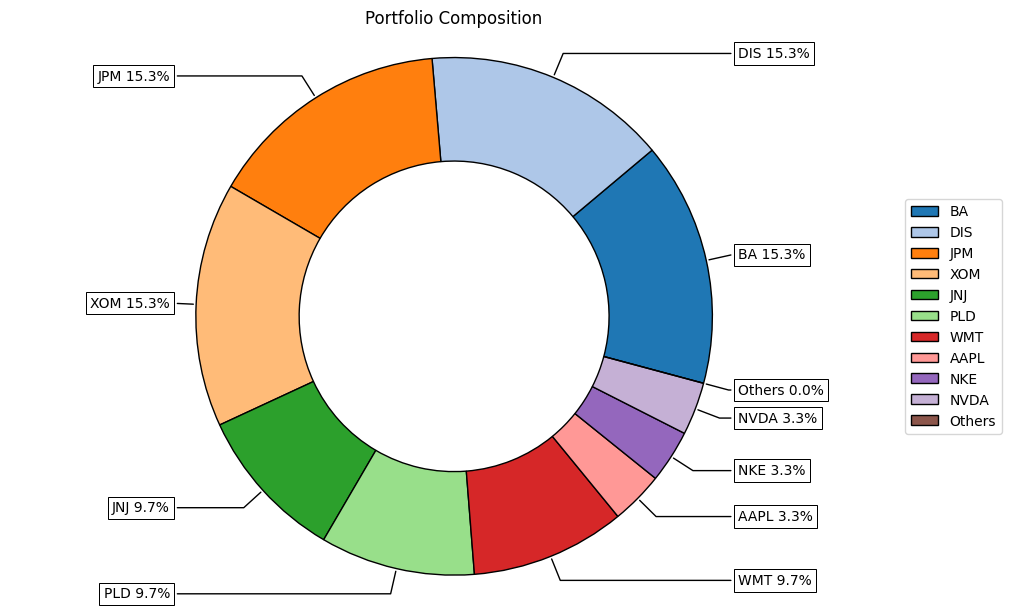

In [7]:
import riskfolio as rp
import matplotlib.pylab as plt

clustered_assets = pd.Series(
    hr.cut_tree(linkage_matrix, n_clusters=k).flatten(), index=cov.index
)

for i in range(k):
    cluster = clustered_assets.loc[clustered_assets == i]
    cluster_weights = pd.Series(np.ones(len(cluster)) / len(cluster), index = cluster.index)
    weights.loc[cluster_weights.index] *= cluster_weights


fig, ax = plt.subplots(figsize = (10, 6))
ax = rp.plot_pie(weights, title = "", others = 0.01, ax = ax)

### Potential Advantages of Hierarchical Clustering for Portfolio Allocation

Applications of hierarchical clustering for determining portfolio allocation have been developed due to practical shortcomings of traditional portfolio optimization. Portfolios constructed by these approaches often have better ouf of sample performance. A few argumets why this is the case are:

- **Captures asset dependencies naturally**  
  Hierarchical clustering organizes assets based on their pairwise relationships (e.g., correlations), allowing the portfolio structure to reflect real-world similarities and differences between assets.

- **Reduces reliance on covariance matrix inversion**  
  Traditional mean-variance optimization requires inverting the covariance matrix, which can be unstable and sensitive to estimation errors. Hierarchical methods avoid direct inversion, improving robustness.

- **Creates interpretable asset groupings**  
  Clustering reveals natural groups of assets (e.g., sectors, factors) which can be intuitively understood and incorporated into allocation decisions.

- **Provides structured diversification**  
  By splitting allocations across increasingly smaller and more similar groups, hierarchical methods promote diversification at multiple levels (between sectors, then within sectors, etc.).

- **Handles noisy financial data more robustly**  
  Clustering focuses on relative relationships between assets rather than absolute estimates, making the resulting allocations less sensitive to estimation noise.

- **Flexible with different risk measures**  
  Recursive bisection and allocation schemes based on clustering can accommodate various risk measures (variance, Value-at-Risk, Expected Shortfall), offering flexibility depending on investment objectives.

- **Scales well with large asset universes**  
  Hierarchical methods can handle a large number of assets without requiring unrealistic amounts of data to estimate stable covariance structures.

- **Aligns with real-world investment constraints**  
  Grouping assets first by similarity can make it easier to integrate practical constraints (such as sector caps, regional exposure limits) into portfolio construction.


### Literature

Note that this subsection described the idea of hierarchical clustering for portfolio allocation. A few academic contributions have developed and advanced these concepts. If you are interested in the details, you may want to go through:

- López de Prado M. (2016) Building diversified portfolios that outperform out of sample. J Portfolio Manag 42(4):59–69. https://doi.org/10.3905/jpm.2016.42.4.059
- Raffinot T. (2017) Hierarchical clustering-based asset allocation. J Portfolio Manag 44(2):89–99. https://doi.org/10.3905/jpm.2018.44.2.089
- Raffinot T. (2018) The hierarchical equal risk contribution portfolio. https://doi.org/10.2139/ssrn. 3237540
- López de Prado M., J. Lewis M. (2019) Detection of false investment strategies using unsupervised learning methods. Quantit Financ 19(9):1555–1565. https://doi.org/10.1080/14697688.2019. 1622311

## Applications of Machine Learning to Prediction

Having introduced key concepts for organizing and clustering financial assets, we now turn to another major application of machine learning in finance: the **prediction of asset returns** and **directional price movements**. In recent years, a growing body of academic research has explored the use of machine learning techniques to forecast excess returns and classify whether asset prices will move up or down.

These studies typically apply supervised learning models to historical financial and economic data, aiming to uncover complex patterns that traditional linear models might miss. Common approaches include regression-based models for return prediction and classification models for forecasting price direction. In the following sections, we review selected examples from the top literature, illustrating how machine learning methods are used in practice to address the challenges of return predictability in noisy and dynamic financial environments.

### Predicting Asset Returns

Three popular academic contributions which tackle regression taks with a large number of machine learning algorithms are:

- Gu S., Kelly, B., Dacheng, X. (2020) Empirical asset pricing via machine learning. Review of Financial Studies 33(5):2223-2273. https://doi.org/10.1093/rfs/hhaa009
- Bianchi D., Büchner M., Tamoni A. (2021) Bond risk premimums with machine learning. Review of Financial Studies 34(2):1046-1089. https://doi.org/10.1093/rfs/hhaa062
- Bali T.G., Beckmeyer H., Mörke M., Weigert F. (2023) Option returns predictability with machine learning and big data. Review of Financial Studies 36(9):3548-3602. https://doi.org/10.1093/rfs/hhad017

There are many similarities between these papers except for the asset class for which they create predictions. Gu et al. (2020) predict excess returns of stocks, Bianchi et al. (2021) predict bond returns and Bali et al. (2023) option returns. What unites these papers is that they use a large amount of data with a relatively long history. The data frequency is usually at a monthly level. 

Each paper uses a training, validation and test set to estimate parameters, optimize hyperparameters and evaluate true out of sample performance. Usually these data subsamples are used in a rolling manner over time. The evaluation is done by a pseudo coefficient of determination. The original **coefficient of determination** is denoted as $R^2$ and measures the proportion of the variance in the dependent variable that is predictable from the independent variables. 

Formally, $R^2$ is defined as:

$$
R^2 = 1 - \frac{\text{SS}_{\text{res}}}{\text{SS}_{\text{tot}}} = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}
$$

where:
- $\text{SS}_{\text{res}} = \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$ is the **residual sum of squares**, representing the unexplained variance,
- $\text{SS}_{\text{tot}} = \sum_{i=1}^{n} (y_i - \bar{y})^2$ is the **total sum of squares**, representing the total variance in the data,
- $y_i$ are the observed values,
- $\hat{y}_i$ are the predicted values from the model,
- $\bar{y}$ is the mean of the observed values.

The residual sum of squares is lower, the closer predictions of the model $\hat{y}_i$ are to the actual realizations $y_i$. The total sum of squares can be interpreted as the performance of a naive prediction model which excludes feature variables and predicts each observation with the average realization $\bar{y}$. The better the model is in identifying the relationship between feature variables and the target variable (asset returns), the closer its predictions should be in comparison to the naive prediction. 

- $R^2 = 1$: perfect prediction; the model explains all variability in the response variable.
- $R^2 = 0$: the model explains no variability beyond the mean of the data.
- $0 < R^2 < 1$: the model explains a portion of the variability.
- In some cases (especially in out-of-sample evaluations), $R^2$ can be negative, indicating that the model performs worse than simply predicting the mean.

In comparison, academic contributions in the financial domain often use a slightly different definition which replaces $\bar{y}$ with $0$ which gives us:

$$
R_{adj}^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} y_i^2}
$$

That means the naive prediction against which the machine learning algorithms do compete states that the (excess) returns is equal to zero. The out of sample values of this adjusted metric seem relatively low, e.g., $R_{adj}^2 = 0.004$ for the best model to predict monthly excess returns of stocks. Nevertheless, the results are remarkable because of market efficiency. For efficient markets, it should be impossible to consistently outperform random guessing. The comparison to simpler models in these papers show that traditional and less flexible models such as linear regression fail to generate positive values for $R_{adj}^2$. If the positive value is enough in the presence of transaction costs and other market frictions depends on the management of these prediction signals. Note that each of these papers also reveal the most important features for prediction. This is an essential step for economicly meaningful applications of machine learning algorithms. 

### Predicting Price Trends

Another publication from a top tier financial journal is given by:

- Jiang J., Kelly B., Dacheng X. (2023) (Re-)Imag(in)ing price trends. The Journal of Finance 78(6):3193-3249. https://doi.org/10.1111/jofi.13268

Forward neural networks as discussed in the last chapter may be seen as the simplest architecture for this flexible model family. The paper by Jiang et al. (2023) utilizes the architecture of Convolutional Neural Networks (CNN) to predict if stock prices move up or down within a period of the near future. CNNs are popular for their usefulness of image processing. I.e., whenever an image is the input to create an output prediction, CNNs are a natural choice given the way their convolutional architecture processes this input data. 

In the paper, **OHLC charts** are used as image input. The task is a binary classification which predicts if the stock price rises or not. See the cell for an example OHLC chart. An OHLC chart (Open-High-Low-Close chart) is a type of financial chart used to represent the price movements of an asset over a specific period, such as a day, week, or month. Each observation is visualized using a vertical line and two horizontal ticks:

- The **vertical line** spans from the **low** to the **high** price during the period.
- A **left-facing tick** marks the **opening price**, and a **right-facing tick** marks the **closing price**.

This format provides a compact summary of four key data points for each time interval:
- **Open**: The first traded price in the interval.
- **High**: The highest price reached.
- **Low**: The lowest price reached.
- **Close**: The last traded price.

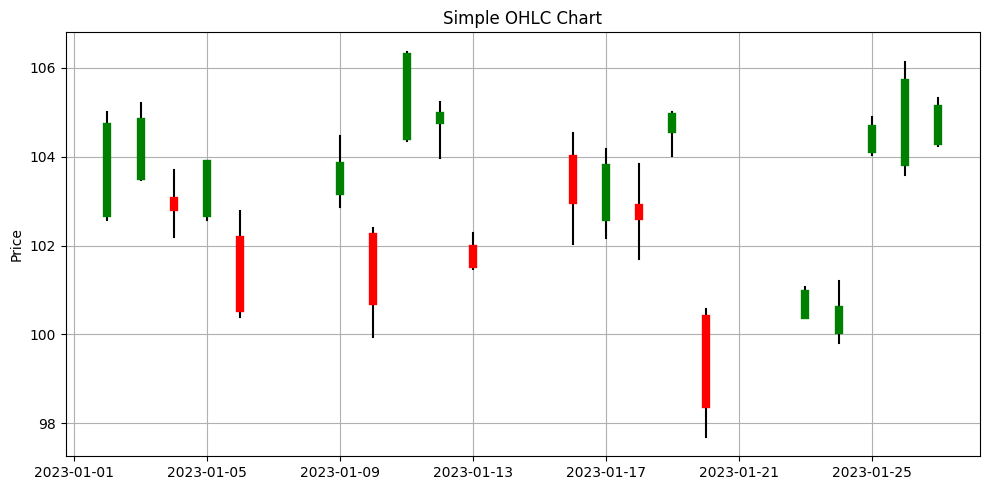

In [8]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# Generate sample OHLC data
np.random.seed(0)
dates = pd.date_range("2023-01-01", periods=20, freq="B")
open_prices = np.random.uniform(100, 105, size=20)
close_prices = open_prices + np.random.uniform(-2, 2, size=20)
high_prices = np.maximum(open_prices, close_prices) + np.random.uniform(0, 1, size=20)
low_prices = np.minimum(open_prices, close_prices) - np.random.uniform(0, 1, size=20)

ohlc_data = pd.DataFrame({
    "Date": dates,
    "Open": open_prices,
    "High": high_prices,
    "Low": low_prices,
    "Close": close_prices
})

# Prepare for plotting
fig, ax = plt.subplots(figsize=(10, 5))
dates_num = mdates.date2num(ohlc_data["Date"])

for i in range(len(ohlc_data)):
    color = 'green' if ohlc_data["Close"][i] >= ohlc_data["Open"][i] else 'red'
    ax.plot([dates_num[i], dates_num[i]], [ohlc_data["Low"][i], ohlc_data["High"][i]], color='black')
    ax.plot([dates_num[i], dates_num[i]], [ohlc_data["Open"][i], ohlc_data["Close"][i]], color=color, linewidth=6)

ax.xaxis_date()
ax.set_title("Simple OHLC Chart")
ax.set_ylabel("Price")
plt.grid(True)
plt.tight_layout()
plt.show()


The paper revisits the idea of trend-based return predictability by applying deep learning, specifically convolutional neural networks (CNNs), to images of stock price charts. Instead of relying on predefined technical indicators like momentum or reversal, the authors use CNNs to automatically learn which patterns in stock price and volume plots are predictive of future returns.

As input to the model historical price and volume data (OHLC, moving average, volume) are transformed into black-and-white images. This includes 5-, 20-, and 60-day intervals, representing weekly, monthly, and quarterly time frames. A CNN is trained to classify whether the return following a price pattern will be positive or not, for various forecast horizons. Probabilities of future positive returns are estimated, and stocks are sorted into deciles based on these predictions to form portfolios.

The most important findings are:

- CNN-based predictions significantly outperform traditional strategies like momentum and short-term reversal, especially at short horizons.
- Equal-weight long-short portfolios formed using CNN signals yield very high out-of-sample Sharpe ratios (up to **7.2**), compared to much lower Sharpe ratios from traditional strategies.
- CNN-based strategies remain profitable even after accounting for transaction costs and when rebalancing at lower frequencies.
- The models generalize well: short-term image patterns can predict long-term returns, and models trained on U.S. stocks also work in international markets.
- Interpretation of the CNN is difficult, but the authors provide some insights by approximating the model with logistic regressions and highlighting pattern-based features (e.g., prices closing near recent lows predict higher returns).

The paper is a notable advancement in the literature on technical analysis and machine learning in finance for several reasons:

- **Nonlinear Feature Extraction**: By using CNNs, the authors bypass the need for manual feature engineering. The model directly learns from raw pixel data, enabling the discovery of complex, nonlinear patterns.
- **Bridging Technical Analysis and Empirical Finance**: The paper shows that techniques inspired by traditional chart-based technical analysis can be formalized and enhanced using modern deep learning, achieving stronger performance and better generalization.
- **Transfer Learning and Robustness**: The finding that models trained on U.S. data perform well internationally and across different time scales adds practical relevance. It supports the idea that certain price formation mechanisms are consistent across contexts.
- **Challenges Remain**: While results are impressive, interpretability remains an issue. Moreover, high-frequency trading strategies based on CNN predictions involve substantial turnover, though lower-frequency applications remain feasible.

## Conclusion

While this chapter has focused on selected applications of machine learning in finance—such as asset clustering, return prediction, and the use of image-based models—many other promising areas remain. Techniques like credit risk classification, fraud detection, and asset allocation through reinforcement learning are actively being explored and applied in both academic research and industry.

The goal of this chapter is not to provide an exhaustive overview, but rather to give readers a solid understanding of how machine learning methods are being adapted to the unique challenges and characteristics of financial data. These include high noise-to-signal ratios, non-stationarity, the importance of interpretability, and the need for robust out-of-sample performance.

By highlighting a few concrete examples and practical techniques, we hope to equip readers with a foundation to critically engage with the growing body of machine learning applications in finance—and to inspire further exploration of this rapidly evolving field.